### Model selection for an ARMA(p,q) 
So far we did not bother about choosing the model order. However, this is a delicate task since the acf and pacf plots no longer help in this respect. Instead we will focus on the Akaike information criterion (AIC) as a goodness-of-fit measure that is comparable across various model dimensions. It is defined as

$$
AIC(p,q) = -2\cdot \log(L(\vec \theta, \vec x )) + 2(p + q + 1)
$$

Here $L$ is the likelihood function of the problem and $\vec\theta$ the vector of all unknown parameters in the model. The vector $\vec x$ contains the time series data that we want to model. For a fitted model - let us choose arbitrarily the model ARIMA(2,1,2) - the AIC value can be retrieved. 

In [1]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("data/temperatures.csv")
df['Year'] = pd.to_datetime(df['Year'], format="%Y")
df.set_index('Year', drop = True, inplace=True)
df.dropna(axis = 0, inplace = True)
model = ARIMA(df.Value, order = (2,1,2))
res = model.fit()
print(res.aic)

125.28563917180563


The model predictions look as follows:

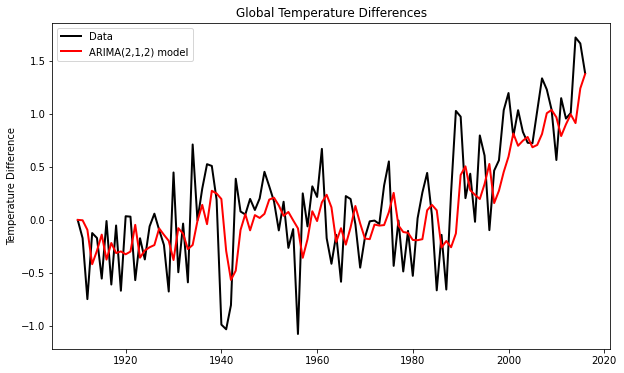

In [2]:
# Plot the original data

temp = df['Value']
plt.figure(figsize=(10, 6))
plt.plot(temp, label='Data', color='black', linewidth=2)
plt.plot(temp - res.resid, label='ARIMA(2,1,2) model', color='red', linewidth=2)
plt.title("Global Temperature Differences")
plt.ylabel("Temperature Difference")
plt.legend()
plt.show()

How do we determine the differencing order $d$ and the order parameters $p$ for the AR(p) process and $q$ for the MA(q) process?

### STEP 1 : Determine the Differencing Order d

We start with order $d=1$, i.e., we compute the differences of the temperatures

$$
Y_n = X_{n} - X_{n-1} = (1 - B) X_n
$$

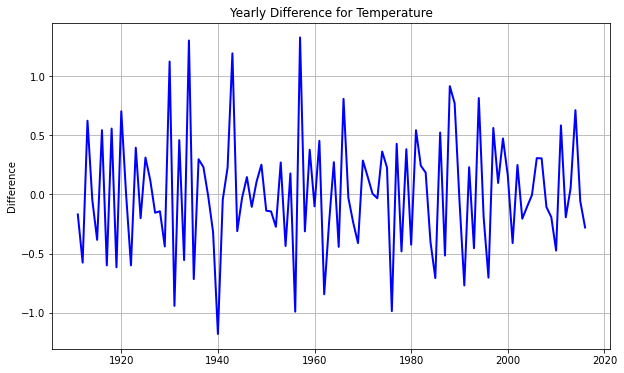

In [3]:
# Extract the temperature column
temp = df['Value']

# Plot the first order difference
plt.figure(figsize=(10, 6))
plt.plot(temp.diff(), label='Yearly Difference', color='blue', linewidth=2)
plt.title("Yearly Difference for Temperature")
plt.ylabel("Difference")
plt.grid(True)
plt.show()


The trend is not any more visible. Thus, we choose $d=1$ as differencing order.

### STEP 2 : Determine the Order Parameters p and q

We now simply loop over a range of candidate model and select the best model in terms of the lowest AIC value. This is a brute force method that is limited by the amount of candidate model that we consider.

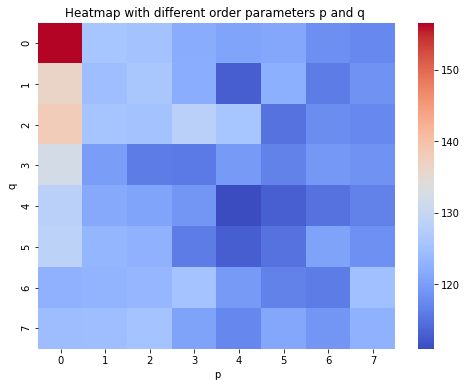

In [4]:
from itertools import product
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

ar = np.arange(8)
ma = np.arange(8)

AIC = np.zeros((8,8))
for comb in product(ar, ma):
    p = comb[0]
    q = comb[1]
    model = ARIMA(temp, order = (p,1,q))
    res = model.fit()
    AIC[p,q] = res.aic

plt.figure(figsize=(8, 6))
ax = sns.heatmap(AIC, cmap='coolwarm')


# Labeling
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_title('Heatmap with different order parameters p and q ')
plt.show()

On the basis of the heatmap, we choose $p=4$ and $q=4$ which shows the lowest AIC value.

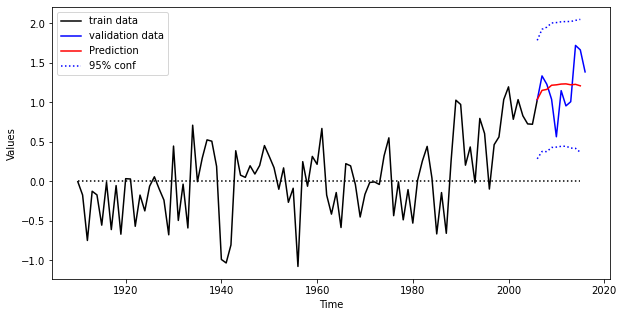

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA



# Fit the ARIMA model
model_opt = ARIMA(temp["1910":"2006"], order=(4, 1, 4)).fit()

# Predict including confidence interval
pred = model_opt.get_prediction(start="2007", end="2016")
pred = pred.prediction_results
pred_cov = pred._forecasts_error_cov
pred = pred._forecasts[0]
pred_upper = pred + 1.96 * np.sqrt(pred_cov[0][0])
pred_lower = pred - 1.96 * np.sqrt(pred_cov[0][0])

# Plot
x = temp.index.year
x_pred = np.arange(2006, 2016)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x[:97], temp["1910":"2006"], '-k', label='train data')
ax.plot(x[96:], temp["2006":"2016"], 'b', label='validation data')
ax.plot(x_pred, pred, 'r', label='Prediction')
ax.plot(x_pred, pred_upper, ':b', label='95% conf')
ax.plot(x_pred, pred_lower, ':b')
ax.plot([x[0], x_pred[-1]], [0, 0], ':k')
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.show()


### Performance Metrics: MAE 

In [6]:
# Actual values for the prediction period
observed_values = temp["2007":"2016"]
pred = model_opt.get_prediction(start="2007", end="2016")
pred = pred.prediction_results
predicted_values = pred._forecasts[0]

# Calculating MAE
mae = np.mean(np.abs(predicted_values - observed_values))
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.28405364342049977


### Performance Metrics: RMSE 

In [7]:
# Calculating RMSE
rmse = np.sqrt(np.mean((predicted_values - observed_values) ** 2))
print("Root Mean Square Error (RMSE):", rmse)

Root Mean Square Error (RMSE): 0.3374063731971506


### Performance Metrics: MAPE 

In [80]:
# Calculating MAPE
mape = np.mean(np.abs((observed_values - predicted_values) / observed_values)) * 100
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

Mean Absolute Percentage Error (MAPE): 28.183511909215675 %


### Performance Metrics: Quartile Score

In [81]:
import scipy.stats as stats

# Forecast
forecast_length = len(predicted_values)
forecast_result = model_opt.get_forecast(steps=forecast_length)
forecast_mean = forecast_result.predicted_mean
forecast_std = np.sqrt(forecast_result.var_pred_mean)

# Function to compute quantile forecasts
def compute_quantile_forecasts(mean, std, quantiles):
    forecasts = {}
    for quantile in quantiles:
        z_score = stats.norm.ppf(quantile)
        forecasts[quantile] = mean + z_score * std
    return forecasts

# Quantiles to compute
quantiles = [0.25, 0.5, 0.75]

# Compute quantile forecasts
quantile_forecasts = compute_quantile_forecasts(forecast_mean, forecast_std, quantiles)

# Function to calculate pinball loss
def pinball_loss(y_true, y_pred, quantile):
    delta = y_true - y_pred
    return np.mean(np.where(delta >= 0, quantile * delta, (quantile - 1) * delta))

# Calculate quartile scores for each quantile forecast
quartile_scores = {}
for quantile in quantiles:
    quartile_scores[quantile] = pinball_loss(observed_values, quantile_forecasts[quantile], quantile)

# Display the quartile scores
for quantile, score in quartile_scores.items():
    print(f"Quartile score for quantile {quantile}: {score}")

Quartile score for quantile 0.25: 0.11002539691208188
Quartile score for quantile 0.5: 0.14202682171024988
Quartile score for quantile 0.75: 0.10686929211629936
